In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
from keras.applications.resnet import ResNet50,preprocess_input
from keras import Model
from keras.preprocessing import image
from time import time
import pickle
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [44]:
from keras.layers import Input,Convolution2D,Flatten,Dense,Dropout,add
import tensorflow as tf
from keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from keras.utils.np_utils import to_categorical
from keras.models import load_model


In [6]:

model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [7]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [8]:
model_new=Model(model.input, model.layers[-2].output)

In [9]:
def preprocessing_img(img):
  img=image.load_img(img,target_size=(224,224))
  img=image.img_to_array(img)
  img=np.expand_dims(img,axis=0)
  img=preprocess_input(img)
  return img

In [10]:

img=preprocessing_img("/content/FB_IMG_16098546496277771.jpg")

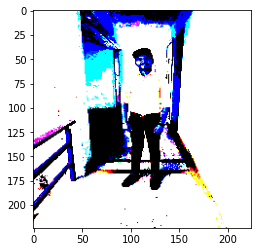

In [11]:
plt.imshow(img[0])
plt.show()

In [12]:
def encode_image(img):
  img=preprocessing_img(img)
  feature_vector=model_new.predict(img)
  print(feature_vector.shape)
  feature_vector=feature_vector.reshape((-1))
  return feature_vector

In [13]:
s=encode_image("/content/FB_IMG_16098546496277771.jpg")

(1, 2048)


In [14]:
s

array([0.16876614, 0.35664248, 0.01597933, ..., 1.6203781 , 0.06235431,
       0.45711124], dtype=float32)

In [15]:
encoding_train={}
train=[]
img_path="#"

In [16]:
# image preprocessing for training
start=time()
for ix ,img_id in enumerate(train):
  imgpath=img_path+"/"+".jpg"
  encoding_train[img_id]=encode_image(imgpath)
  if ix%100==0:
    print("encoding is running",ix)
end=time()
print("total time",end-start)



total time 0.00014400482177734375


In [17]:
with open("encoded_train_feature.pkl","wb") as f:
  pickle.dump(encoding_train,f)

In [18]:
encoding_test={}
test=[]

In [19]:
# image preprocessing for test
start=time()
for ix ,img_id in enumerate(test):
  imgpath=img_path+"/"+".jpg"
  encoding_test[img_id]=encode_image(imgpath)
  if ix%100==0:
    print("encoding is running",ix)
end=time()
print("total time",end-start)

total time 0.00012755393981933594


In [20]:
with open("encoded_test_feature.pkl","wb") as f:
  pickle.dump(encoding_test,f)

In [36]:
def data_generator(train_descriptin,encoding_train,word_to_idx,max_len,vocab_size):
  x1,x2,y=[],[],[]
  n=0
  while True:
    for key,desclist in train_descriptin.items():
      n+=1
      photo=encoding_train[key+".jpg"]
      for desc in desclist:
        seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
        for i in range(1,len(seq)):
          xi=seq[0:i]
          yi=seq[i]
          xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')
          yi=to_categorical([yi],num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(xi)
          y.append(yi)
      if n==vocab_size:
        yield [[np.array(x1),np.array(x2)],np.array(y)]
        x1,x2,y1=[],[],[]
        n=0
        






In [22]:

input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation="relu")(inp_img1)

In [23]:
max_len=35
vocab_size=1848

In [24]:
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [25]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation="relu")(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

In [26]:
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [1]:
embedding_matrix=[[]]

In [29]:
#model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [31]:
####model train

In [33]:
train_description={}

In [35]:
epoch=20
batch_size=3
steps=len(train_description)//batch_size

In [37]:
def train(epoch,batch_size,train_description,encoding_train,word_to_idx,max_len,steps):
  generator=data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
  model.fit_generator(generator,epochs=1,step_per_epoch=steps,verbuse=1)
  model.save('./model_weights/model_'+str(i)+'.h5')
  

In [43]:
#model=load_model('./model_weights/model_9.h5')

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
